<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education - EA  Python Course Spring 2021

## Important  - Assignment Guidelines

1. Before you submit your assignment to GitHub, make sure to run the entire notebook with a fresh kernel. To do this first, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Always replace the `raise NotImplementedError()` code with your code that addresses the activity challenge. If you don't replace that code, your notebook will not run.

```
# YOUR CODE HERE
raise NotImplementedError()
```

3. Any open ended questions will have a "YOUR ANSWER HERE" within a markdown cell. Replace that text with your answer also formatted using Markdown.
4. **DO NOT RENAME THIS NOTEBOOK File!** If the file name changes, the autograder will not grade your assignment properly.
6. When you create a figure, comment out `plt.show()` to ensure the autograder can grade your plots. For figure cells, DO NOT DELETE the code that says `DO NOT REMOVE LINE BELOW`.

```
### DO NOT REMOVE LINE BELOW ###
student_plot1_ax = nb.convert_axes(plt)
```

* Only include the package imports, code, and outputs that are required to run your homework assignment.
* Be sure that your code can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible
   2. all paths should be created dynamically using the `os.path.join`

## Follow to PEP 8 Syntax Guidelines & Documentation

* Run the `autopep8` tool on all cells prior to submitting (HINT: hit shift + the tool to run it on all cells at once!
* Use clear and expressive names for variables. 
* Organize your code to support readability.
* Check for code line length
* Use comments and white space sparingly where it is needed
* Make sure all python imports are at the top of your notebook and follow PEP 8 order conventions
* Spell check your Notebook before submitting it.

For all of the plots below, be sure to do the following:

* Make sure each plot has a clear TITLE and, where appropriate, label the x and y axes. Be sure to include UNITS in your labels.


### Add Your Name Below 
**Carson Norris**

# Week 04 and 05 Homework - Automate NDVI Workflow

For this assignment, you will write code to generate a plot of the mean normalized difference vegetation index (NDVI) for two different sites in the United States across one year of data:

* San Joaquin Experimental Range (SJER) in Southern California, United States
* Harvard Forest (HARV) in the Northeastern United States

The data that you will use for this week is available from **earthpy** using the following download: 

`et.data.get_data('ndvi-automation')`

## Assignment Goals

Your goal in this assignment is to create the most efficient and concise workflow that you can that allows for:

1. The code to scale if you added new sites or more time periods to the analysis.
2. Someone else to understand your workflow.
3. The LEAST and most efficient (i.e. runs fast, minimize repetition) amount of code that completes the task.

### HINTS

* Remove values outside of the landsat valid range of values as specified in the metadata, as needed.
* Keep any output files SEPARATE FROM input files. Outputs should be created in an outputs directory that is created in the code (if needed) and/or tested for.
* Use the functions that we demonstrated during class to make your workflow more efficient.
* BONUS - if you  chose - you can export your data as a csv file. You will get bonus points for doing this.


## Assignment Requirements

Your submission to the GitHub repository should include:
* This Jupyter Notebook file (.ipynb) with:
    * The code to create a plot of mean NDVI across a year for  2 NEON Field Sites:
        * NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object
    * The **data should be cleaned to remove the influence of clouds**. See the [earthdatascience website for an example of what your plot might look like with and without removal of clouds](https://www.earthdatascience.org/courses/earth-analytics-python/create-efficient-data-workflows/).
* BONUS: Create one output `.csv` file that has 3 columns - NDVI, Date and Site Name - with values for SJER and HARV.

Your notebook should:
* Have *at least* 2 well documented and well named functions with docstrings.
* Include a Markdown cell at the top of the notebook that outlines the overall workflow using pseudocode (i.e. plain language, not code)
* Include additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

<img style="float: left;" src="colored-bar.png"/>

---

# Replace this cell with your pseudocode  for this workflow

If you happen to be a diagram person a diagram is ok too




# High Level Overview

**1. Loop through each landsat directory of tif files (each scene)**

   * create a list of paths to directories for both scenes
   * in each loop iteration, grab the date from the directory name
   * create an empty dictionary with a key for that date
    
**2. Create a list of all tif files that you will need in the scene's directory**

**3. Open / crop / clean the tif files that  you need for your analysis**

**4. Optional: combine into a single object?**

**5. Calculate veg indices**

   * NDVI
   * NBR / dNBR
   
**6. Landsat  Data Only: Apply cloud  mask  to  final  NBR /  NDVI  layers**

In [1]:
# Autograding imports - do not modify this cell
import matplotcheck.autograde as ag
import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
from datetime import datetime

In [2]:
# Import needed packages in PEP 8 order
# and no unused imports listed (10 points total)
import os
import pyproj
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import geopandas as gpd 
import xarray as xr 
import rioxarray as rxr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

# Get data
data = et.data.get_data('ndvi-automation')

# Set working directory
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))


ndvi-automation\sites\HARV\
ndvi-automation\sites\SJER\


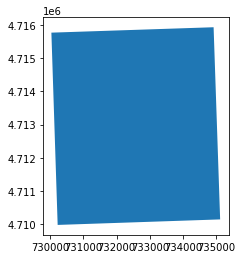

<xarray.DataArray (y: 200, x: 171)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 7.3e+05 7.300e+05 7.301e+05 ... 7.351e+05 7.351e+05
  * y            (y) float64 4.716e+06 4.716e+06 4.716e+06 ... 4.71e+06 4.71e+06
    band         int32 1
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [9]:
# Site data
path = os.path.join('ndvi-automation', 'sites')

sites = glob(path + "/*/")
for site_files in sites:
    print(site_files)

site_name = os.path.basename(os.path.normpath(sites[0]))

# Shapefile data
vector_dir = os.path.join(sites[0], "vector")

# Create boundary
site_boundary_path = os.path.join(vector_dir, site_name + "-crop.shp")
crop_bound = gpd.read_file(site_boundary_path)
crop_bound.plot()
plt.show()

# landsat directory with .tif files
landsat_dir = os.path.join(sites[0], "landsat-crop")
landsat_dirs = glob(os.path.join(landsat_dir, "LC08*"))
landsat_dirs.sort()
# print(landsat_dirs)

# Select a single directory and grab bands 4-5 from directory
adir = landsat_dirs[3]

# Open bands
band_paths = glob(os.path.join(adir, "*band*[4-5].tif"))
band_paths.sort()
band_paths

# Open cloud mask layer
# No data values for Landsat 8
# vals = [328, 392, 840, 904, 1350, 352, 368, 416,
#         432, 480, 864, 880, 928, 944, 992, 480, 992]

# Get cloud mask layer
qa_r = glob(os.path.join(adir, "*qa*"))
# qa_r

# Clip cloud mask layer
cl_mask = (rxr.open_rasterio(qa_r[0],
                             masked=True).squeeze().rio.clip(crop_bound.geometry,
                                                             from_disk=True).squeeze())



# Open a single band using rioxarray & mask to valid range then apply cloud mask
band = rxr.open_rasterio(band_paths[0], masked=True).rio.clip(crop_bound.geometry,
                                                              from_disk=True).squeeze()

# Specify the valid range of values for landsat
valid_range = (0, 10000)

if valid_range:
    mask = ((band < valid_range[0]) | (band > valid_range[1]))
    band = band.where(~xr.where(mask, True, False))

band

In [11]:
# In this cell place all of the functions needed to run your notebook
# You will be graded here on function application, docstrings, efficiency so ensure
# All functions are placed here!

# Function A
def open_clean_bands(band_path,
                     valid_range=None):
    """Open and mask a single Landsat band using a pixel_qa layer.

    Parameters
    ----------
    band_path : string
        A path to the array to be opened
    valid_range : tuple (optional)
        A tuple of min and max range values for the data. Default = None

    Returns
    ----------
    arr : xarray DataArray
        An xarray DataArray with values that should be masked set to 1 for
        True (Boolean)
    """
    # Open a single band using rioxarray & mask to valid range then apply cloud mask
    band = (
        rxr.open_rasterio(band_path,
                          masked=True).rio_clip(crop_bound.geometry,
                                                from_disk=True).squeeze())

    # Specify valid range of values
    if valid_range:
        mask = ((band <= 0) | (band > 10000))
        band = band.where(~mask, np.nan)
        
    return band

# Function B
def mask_crop_ndvi(all_bands,
                   crop_bound,
                   pixel_qa_path,
                   vals):
    """Open and mask a single Landsat band using a pixel_qa layer.

    Parameters
    -----------
    all_bands : list 
        A list containing paths to Landsat bands 4 and 5 as .tif files
    crop_bound : geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using
        rasterio mask()
    pixel_qa_path : string
        A path to a pixel qa layer as .tif file
    vals : list
        A list of values needed to create the cloud mask

    Returns
    --------
    mean_ndvi : xarray.DataArray
        A cropped, masked xarray object containing NDVI values

    """
    # Create empty list
    bands = []
    # Open all bands using a loop
    for aband in all_bands:
        clean_bands = open_clean_bands(band_path=aband,
                                       valid_range=(0, 10000))
        bands.append(clean_bands)

    # Clip the cloud mask layer
    cloud_mask = (
        rxr.open_rasterio(band_path,
                          masked=True).squeeze().rio_clip(crop_bound.geometry,
                                                          from_disk=True.squeeze()))
    
    # Calculate NDVI
    ndvi_xr = (bands[1] - bands[0]) / (bands[1] + bands[0])
    
    # Apply cloud mask to NDVI
    all_masked_values = [328, 392, 840, 904, 1350, 352, 368, 416, 
                         432, 480, 864, 880, 928, 944, 992, 480, 992]
   
    ndvi_crop = ndvi_xr.where(~cloud_mask.isin(all_masked_values))

    # NDVI "Mean" values
    mean_ndvi = ndvi_crop.mean(skipna=True).item()
    
    return mean_ndvi 

In [12]:
band_4 = open_clean_bands(band_path=band_paths[0],
                          crop_bound=crop_bound,
                          # The range of valid values for landsat can include negative values
                          # for this week let's stick with 0-10000
                          valid_range=(0, 10000),
                          a_mask=cl_mask,
                          vals=vals)

NameError: name 'vals' is not defined

In [13]:
# V1
# create empty dictionary
landsat_data = {}

# 1. Loop through each landsat dir of tif files (each scene)
# * create a list of paths to dir for both scenes
data_path = os.path.join('ndvi-automation', 'sites')
# view subdirectories of data
all_dirs = glob(os.path.join(data_path, "*/"))


# 2. Loop: create a list of all tif files that you will need in the scene's dir
for landsat_dir in all_dirs:
    all_files = []
    all_files = sorted(glob(os.path.join(data_path,
                                         "*",
                                         "landsat-crop",
                                         "*",
                                         "*.tif")))

    # * in each loop iteration, grab the date from the directory name
    # grab landsat scene name, directory and corresponding date
    landsat_scene = os.path.basename(os.path.normpath(landsat_dir))
    # grab date from each scene
    date = landsat_scene[10:18]
    landsat_data[date] = []

    print("directory: ", landsat_dir)
    print("scene name: ", landsat_scene)
    print("date: ", date)
    print("\n")

 # * create an empty dictionary with a key for that date
all_files
# landsat_data

directory:  ndvi-automation\sites\HARV\
scene name:  HARV
date:  


directory:  ndvi-automation\sites\SJER\
scene name:  SJER
date:  




['ndvi-automation\\sites\\HARV\\landsat-crop\\LC080130302017011201T1-SC20181023151858\\LC08_L1TP_013030_20170112_20170218_01_T1_pixel_qa.tif',
 'ndvi-automation\\sites\\HARV\\landsat-crop\\LC080130302017011201T1-SC20181023151858\\LC08_L1TP_013030_20170112_20170218_01_T1_sr_band1.tif',
 'ndvi-automation\\sites\\HARV\\landsat-crop\\LC080130302017011201T1-SC20181023151858\\LC08_L1TP_013030_20170112_20170218_01_T1_sr_band2.tif',
 'ndvi-automation\\sites\\HARV\\landsat-crop\\LC080130302017011201T1-SC20181023151858\\LC08_L1TP_013030_20170112_20170218_01_T1_sr_band3.tif',
 'ndvi-automation\\sites\\HARV\\landsat-crop\\LC080130302017011201T1-SC20181023151858\\LC08_L1TP_013030_20170112_20170218_01_T1_sr_band4.tif',
 'ndvi-automation\\sites\\HARV\\landsat-crop\\LC080130302017011201T1-SC20181023151858\\LC08_L1TP_013030_20170112_20170218_01_T1_sr_band5.tif',
 'ndvi-automation\\sites\\HARV\\landsat-crop\\LC080130302017012801T1-SC20181023151918\\LC08_L1TP_013030_20170128_20170218_01_T1_pixel_qa.tif',

In [14]:
# V2

# Define directory name
landsat_crop_dir = "landsat-crop"

# Create empty list
ndvi_list = []

# Loop through each site directory
for site_dir in all_site_dirs:
    print("Looping through: ", site_files)
    site_name = os.path.split(os.path.normpath(site_dir[1]))
    
    
    asite = os.path.normpath(site_files).split(os.sep)[-1]
    print("Processing", asite, "field site")
    # Get site name
    site_name = os.path.basename(os.path.normpath(sites[0]))
    print("Site name is: ", site_name)
    # Open shapefile for clipping data to study area
    vector_dir = os.path.join(sites[0], "vector")
    # Open cropped site boundary
    site_boundary_path = os.path.join(vector_dir, site_name + "-crop.shp")
    crop_bound = gpd.read_file(site_boundary_path)
    
    
    

    # Get a list of subdirectories for that site
    
    all_dirs = sorted(glob(os.path.join(site_files,
                                        landsat_dir, "*/")))
    
    # Loop through each subdirectory where the data is stored
    for adir in all_dirs:
        print("Processing", adir)
        # Grab out date from directory name
        dir_name = os.path.basename(os.path.normpath(adir))
        print(dir_name)
        date = dir_name[10:18]
        print("Date: ", date)
        
        # Grab only necessary bands
        all_bands_path = glob(os.path.join(adir, "*band*[4-5].tif"))
        all_bands_path.sort()
        print(all_bands_path)
        
        # Grab QA layer
        pixel_qa_path = glob(os.path.join(adir, "*qa*"))
        print(pixel_qa_path)
        print("\n")
        
        
        # Calculate NDVI
        ndvi_values = mask_crop_ndvi(all_band=all_bands_path,
                                     crop_bound=crop_bound,
                                     pixel_qa_path=pixel_qa_path,
                                     vals=all_masked_values)
        
        # Append NDVI to columns
        outputs = [asite, date, ndvi_values]
        ndvi_list.append(outputs)
        
ndvi_list

NameError: name 'all_site_dirs' is not defined

In [ ]:
#  # Open up shapefile for clipping landsat data to study area; vector
#     vector_dir = os.path.join(site_files, "vector")
#     print(vector_dir)
#     # Open crop boundary
#     site_boundary_path = os.path.join(vector_dir, site_name + "-crop.shp")
#     print(site_boundary_path)
#     crop_bound = gpd.read_file(site_boundary_path)
#     print(crop_bound)
    
#     print("/n")
    

In [ ]:
# # Open shapefile for clipping Landsat data to Site areas
# vector_dir = os.path.join(sites[1],
#                           'vector')

# # Open crop boundary
# site_boundary_path = os.path.join(vector_dir, site_name + "-crop.shp")
# crop_bound = gpd.read_file(site_boundary_path)

# # Test plot
# crop_bound.plot()

In [ ]:
# DO NOT MODIFY THIS CELL
# Tests that the working directory is set to earth-analytics/data

path = os.path.normpath(os.getcwd())
student_wd_parts = path.split(os.sep)

if student_wd_parts[-2:] == ['earth-analytics', 'data']:
    print("\u2705 Great - it looks like your working directory is set correctly to ~/earth-analytics/data")
else:
    print("\u274C Oops, the autograder will not run unless your working directory is set to earth-analytics/data")

# Figure 1: Plot 1 - Mean NDVI For Each Site Across the Year (50 points)

Create a plot of the mean normalized difference vegetation index (NDVI) for the two different sites in the United States across the year: 

* NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object.
* Each site should be identified with a different color in the plot and legend.
* The final plot **data should be cleaned to remove the influence of clouds**.
* Be sure to include appropriate title and axes labels.

Add additional cells as needed for processing data (e.g. defining functions, etc), but be sure to:
* follow the instructions in the code cells that have been provided to ensure that you are able to use the sanity check tests that are provided. 
* include only the plot code in the cell identified for the final plot code below

## Task 1: 

In the cell below, create a single dataframe containing MEAN NDVI, the site name, 
and the date of the data for the HARV site 
scene `HARV/landsat-crop/LC080130302017031701T1-SC20181023151837`.  The column names for the  final
DataFrame should be`mean_ndvi`, and `site`, and the data should be **indexed on the date**. 

Use the functions that we reviewed in class (or create your own versions of them) to implement your code

### In the Cell below Place  All Functions Needed to Run this Notebook (20 points)

In [ ]:
### DO NOT REMOVE THIS LINE OR EDIT / MOVE THIS CELL ###
start_time = datetime.now()

In [ ]:
# Create dataframe of mean NDVI in this cell using the functions created above
# Important: to use the ungraded tests below as a sanity check,
# name your columns: mean_ndvi and site
# Call the dataframe at the end of the cell so the tests run on it!
# Be sure that the date column is an index of type date
# HINT: the time series lessons may help you remember how to do this!



In [ ]:
# This cell  is testing your data output above

student_ndvi_ts_single_site = _

single_scene_points = 0

# Ensure the data is stored in a dataframe.
if isinstance(student_ndvi_ts_single_site, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    single_scene_points += 1
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Ensure that the date column is the index
if isinstance(student_ndvi_ts_single_site.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    single_scene_points += 2
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_ts_single_site.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    single_scene_points += 2
else:
    print('\u274C The data in your date column is not datetime.')

# Ensure the site name is correct
if student_ndvi_ts_single_site.site.values[0] == 'HARV':
    print('\u2705 You have the correct site name!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct site name.')

if np.allclose(0.281131628228094, student_ndvi_ts_single_site.mean_ndvi.values[0]):
    print('\u2705 You have the correct mean NDVI value!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct mean ndvi value.')

print("\n \u27A1 You received {} out of 15 points for creating a dataframe.".format(
    single_scene_points))
single_scene_points

## Task 2:

In the cell below, process all of the landsat scenes. Create a DataFrame that contains the following 
information for each scene


|   | index  | site  | mean_ndvi  | 
|---|---|---|---|
| Date  |   |   |   |
|  2017-01-07  | 0  | SJER  | .4  |  

Be sure to call your dataframe at the end of the cell to ensure autograding works.
HINT: FOR THIS STEP, leave any rows containing missing values (`NAN`).

In [ ]:
# Create dataframe of NDVI including the cleaning data to deal with clouds

# Important: to use the ungraded tests below as a sanity check,
# name your columns: mean_ndvi and site
# Don't forget to set date as the index and make the values of type datetime



In [ ]:
# Last sanity check before creating your plot (10 points)

# Ensure that you call your dataframe at the bottom of the cell above
# and that it has columns called: mean_ndvi and site

# Ensure the data is stored in a dataframe.
student_ndvi_df = _

df_points = 0

if isinstance(student_ndvi_df, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    df_points +=2
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Check that dataframe contains the appropriate number of NAN values
if student_ndvi_df.mean_ndvi.isna().sum() == 15:
    print('\u2705 Correct number of masked data values!')
    df_points +=2
else:
    print('\u274C The amount of null data in your dataframe is incorrect.')


# Ensure that the date column is the index
if isinstance(student_ndvi_df.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    df_points +=3
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_df.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    df_points +=3
else:
    print('\u274C The data in your date column is not datetime.')

# Output for timer, # DO NOT MODIFY
end_time = datetime.now()
total_time = end_time - start_time
print(
    "Your total run time for processing the data was {0}.".format(total_time))

print("\n \u27A1 You received {} out of 10 points for creating a dataframe.".format(
    df_points))

df_points

In [ ]:
# Add only the plot code to this cell

# This is the final figure of mean NDVI
# for both sites across the year
# with data cleaned to deal with clouds

# YOUR CODE HERE
raise NotImplementedError()

### DO NOT REMOVE LINES BELOW ###
final_masked_solution = nb.convert_axes(plt, which_axes="current")

In [ ]:
# Ignore this cell for the autograding tests


In [ ]:
# Ignore this cell for the autograding tests


# Question 1 (10 points)

Imagine that you are planning NEON’s upcoming flight season to capture remote sensing data in these locations and want to ensure that you fly the area when the vegetation is the most green.

When would you recommend the flights take place for each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

YOUR ANSWER HERE

# Question 2 (10 points)

How could you modify your workflow to look at vegetation changes over time in each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

YOUR ANSWER HERE

# Do not edit this cell! (10 points)

The notebook includes:
* additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Do not edit this cell! (20 points)

The notebook will also be checked for overall clean code requirements as specified at the **top** of this notebook. Some of these requirements include (review the top cells for more specifics): 

* Notebook begins at cell [1] and runs on any machine in its entirety.
* PEP 8 format is applied throughout (including lengths of comment and code lines).
* No additional code or imports in the notebook that is not needed for the workflow.
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module.
   * data downloaded using code in the notebook.
   * all imports at top of notebook.

## BONUS - Export a  .CSV File to Share (10 points possible)

This is optional - if you export a **.csv** file with the columns specified above: Site, Date and NDVI Value you can get an additional 10 points.

* FULL CREDIT: File exists in csv format and contains the columns specified.
We will check your github repo for this file!
